# PA005 - High Value Customers Identification (Insiders)

## 0.0 Planejamento da Solução (IOT)

### Input - Entrada

1. Problema de negócio
- Selecionar os clientes mais valiosos para integrar um programa de fidelização.
2. Conjunto de Dados
- Vendas de um e-commerce, durante um certo período.

### Output  - Saída
1. A indicação das pessoas que farão parte do programa de Insiders.
- Lista: client_id| is_insider |

2. Relatório com as respostas das perguntas de negócio.
- Quem são as pessoas elegíveis para participar do programa de Insiders?
- Quantos clientes farão parte do grupo?
- Quais as principais características desses clientes?
- Qual a % de contribuição do faturamento, vinda do Insiders?
- Qual a expectativa de faturamento desse grupo para os próximos meses?
- Quais as condições para uma pessoa ser elegível ao Insiders?
- Quais as condições para uma pessoa ser removida do Insiders?
- Qual a garantia que o programa Insiders é melhor que o restante da base?
- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de alto "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta Previsão LTV.
        - Alta propensão de compra.

    - Custo:
        - Baixa taxa de devolução.
    
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes.
    - % do grupo Insiders.

3. Quais as principais características desses clientes?
    - Escrever características dos clientes:
        - Idade
        - Salário
        - Localização
    
    - Escrever características de consumo:
        - Atributos de clusterização

4. Qual a % de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano.
    - Faturamento do grupo Insiders.

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão do LTV do grupo Insiders.
    - Análise de Cohort.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - teste A/B Bayesiano.
    - Teste de hióteses.
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto.
    - Preferência de compra.
    - Frete.
    - Visita a empresa.

## Benchmark de soluções

### 1.0 Desk Research

# 0.0 Imports

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

import umap.umap_ as umap

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import preprocessing as pp
from sklearn import metrics as mt

## 0.1 Helper Functions

## 0.2 Loading Dataset

In [2]:
# load data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis = 1)

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id','country']
df1.columns = cols_new

## 1.2 Data Dimensions, Types e NA

In [5]:
df1.shape

(541909, 8)

## 1.3 Datatypes

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
# remove na
df1 = df1.dropna(subset=['description','customer_id'])

print(f'Removed data: {1-(df1.shape[0] / df_raw.shape[0])}%')

Removed data: 0.24926694334288602%


## 1.6 Change Datatypes

In [9]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [11]:
# Central Tendecy (Mean and Median)
c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
a

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.1.1 Investigating
1. Quantity negativa (pode ser devolução?)
2. Preço unitário igual a 0 (pode ser promoção?).
3. Preço unitário alto

### 1.7.2 Categorical Attributes

In [25]:
# invoice_no

# df1['invoice_no'] = df1['invoice_no'].astype(int)
df_invoice_no = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), :]
quantity_negative = df_invoice_no.loc[df_invoice_no['quantity'] < 0, 'quantity'].count()

print(f'Quantidade de invoice number com letras: {df_invoice_no.shape[0]} e que tem quantidade negativa: {quantity_negative}')

Quantidade de invoice number com letras: 8905 e que tem quantidade negativa: 8905


In [32]:
# stock_code

# df1['stock_code'] = df1['stock_code'].astype(int)
# len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), 'stock_code'].drop_duplicates())

stock_code_limpeza = list(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x) ) ), 'stock_code'].unique())

print(f'Lista de stock code para limpar: {stock_code_limpeza}')

Lista de stock code para limpar: ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


In [42]:
# country_code
cat_attributes.loc[:, 'country'].value_counts(normalize = True)
cat_attributes.loc[:, 'country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

# 2.0 Filtragem de Variáveis

In [288]:
df2 = df1.copy()

In [289]:
# ======== unit_price ========
df2 = df2[df2['unit_price'] >= 0.04]

# ======== stock_code ========
df2 = df2[~df2['stock_code'].isin(stock_code_limpeza)]

# ======== description ========
df2 = df2.drop(columns='description', axis = 1)
 
# ======== country ========
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# ======== quantity ========
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]


# 3.0 Feature Enginnering

In [291]:
df3 = df2.copy()

## 3.1 Feature Creation

In [292]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity','invoice_date','unit_price','country'], axis = 1).drop_duplicates(ignore_index = True)

In [293]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on ='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_181/4216613857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

In [294]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [295]:
# Frequency 
df_freq = df2_purchases.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [296]:
# Avg ticket
df_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

# 4.0 EDA

In [297]:
df4 = df_ref.dropna()

# 5.0 Data preparation

In [336]:
df5 = df4.copy()

array([[<Axes: title={'center': 'gross_revenue'}>,
        <Axes: title={'center': 'recency_days'}>],
       [<Axes: title={'center': 'invoice_no'}>,
        <Axes: title={'center': 'avg_ticket'}>]], dtype=object)

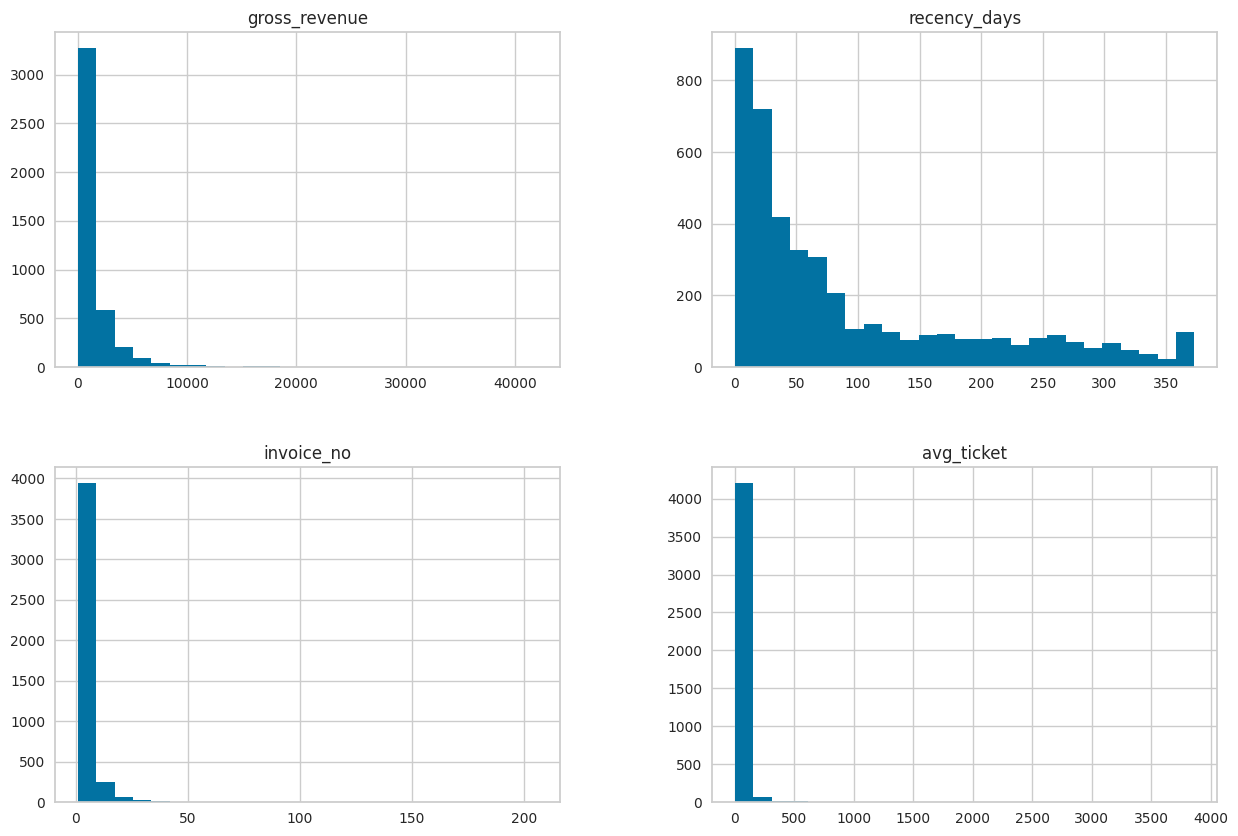

In [245]:
df_hist = df5.drop(columns='customer_id', axis = 1)
df_hist = df_hist[df_hist['gross_revenue'] < 50000]
df_hist = df_hist[df_hist['avg_ticket'] < 4000]
df_hist.hist(bins = 25, figsize= (15,10))

In [337]:
ss = pp.StandardScaler()
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 6.0 Feature Selection

In [338]:
df6 = df5.copy()

# 7.0 HyperParameter Fine-Tunning

In [339]:
X = df6.drop(columns = ['customer_id'])

In [340]:
clusters = np.arange(2, 8, 1)

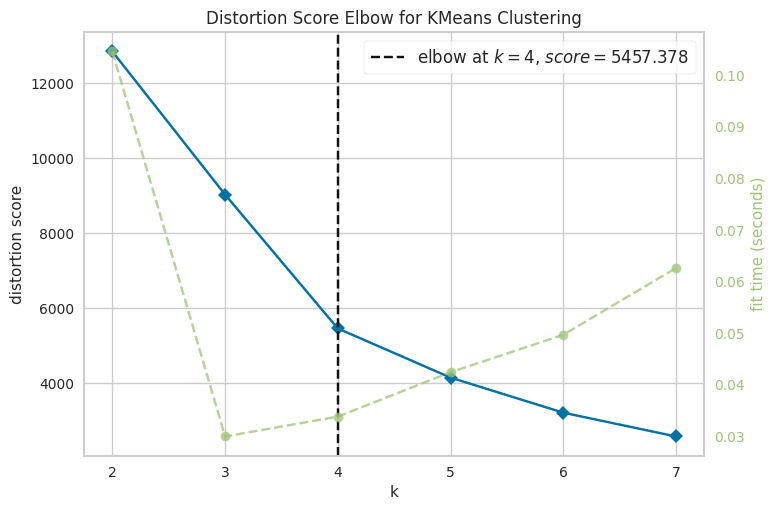

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [341]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans' 
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, timing = True)
kmeans.fit(X)
kmeans.show()

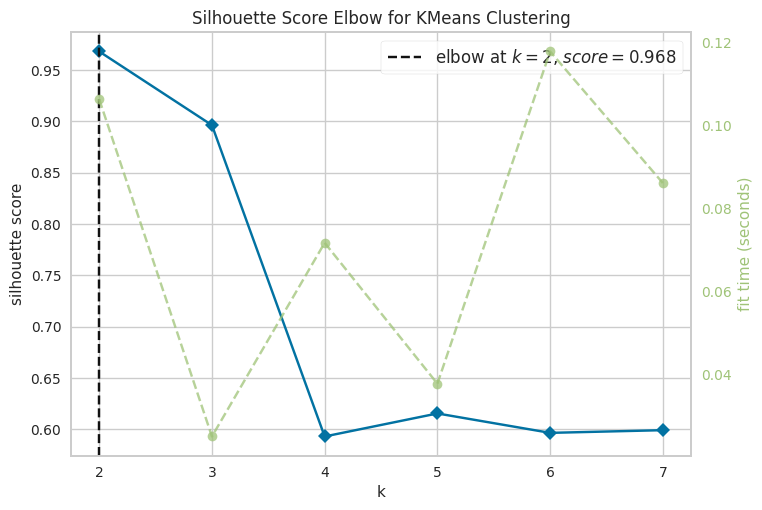

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [342]:
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, metric='silhouette', timing = True)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

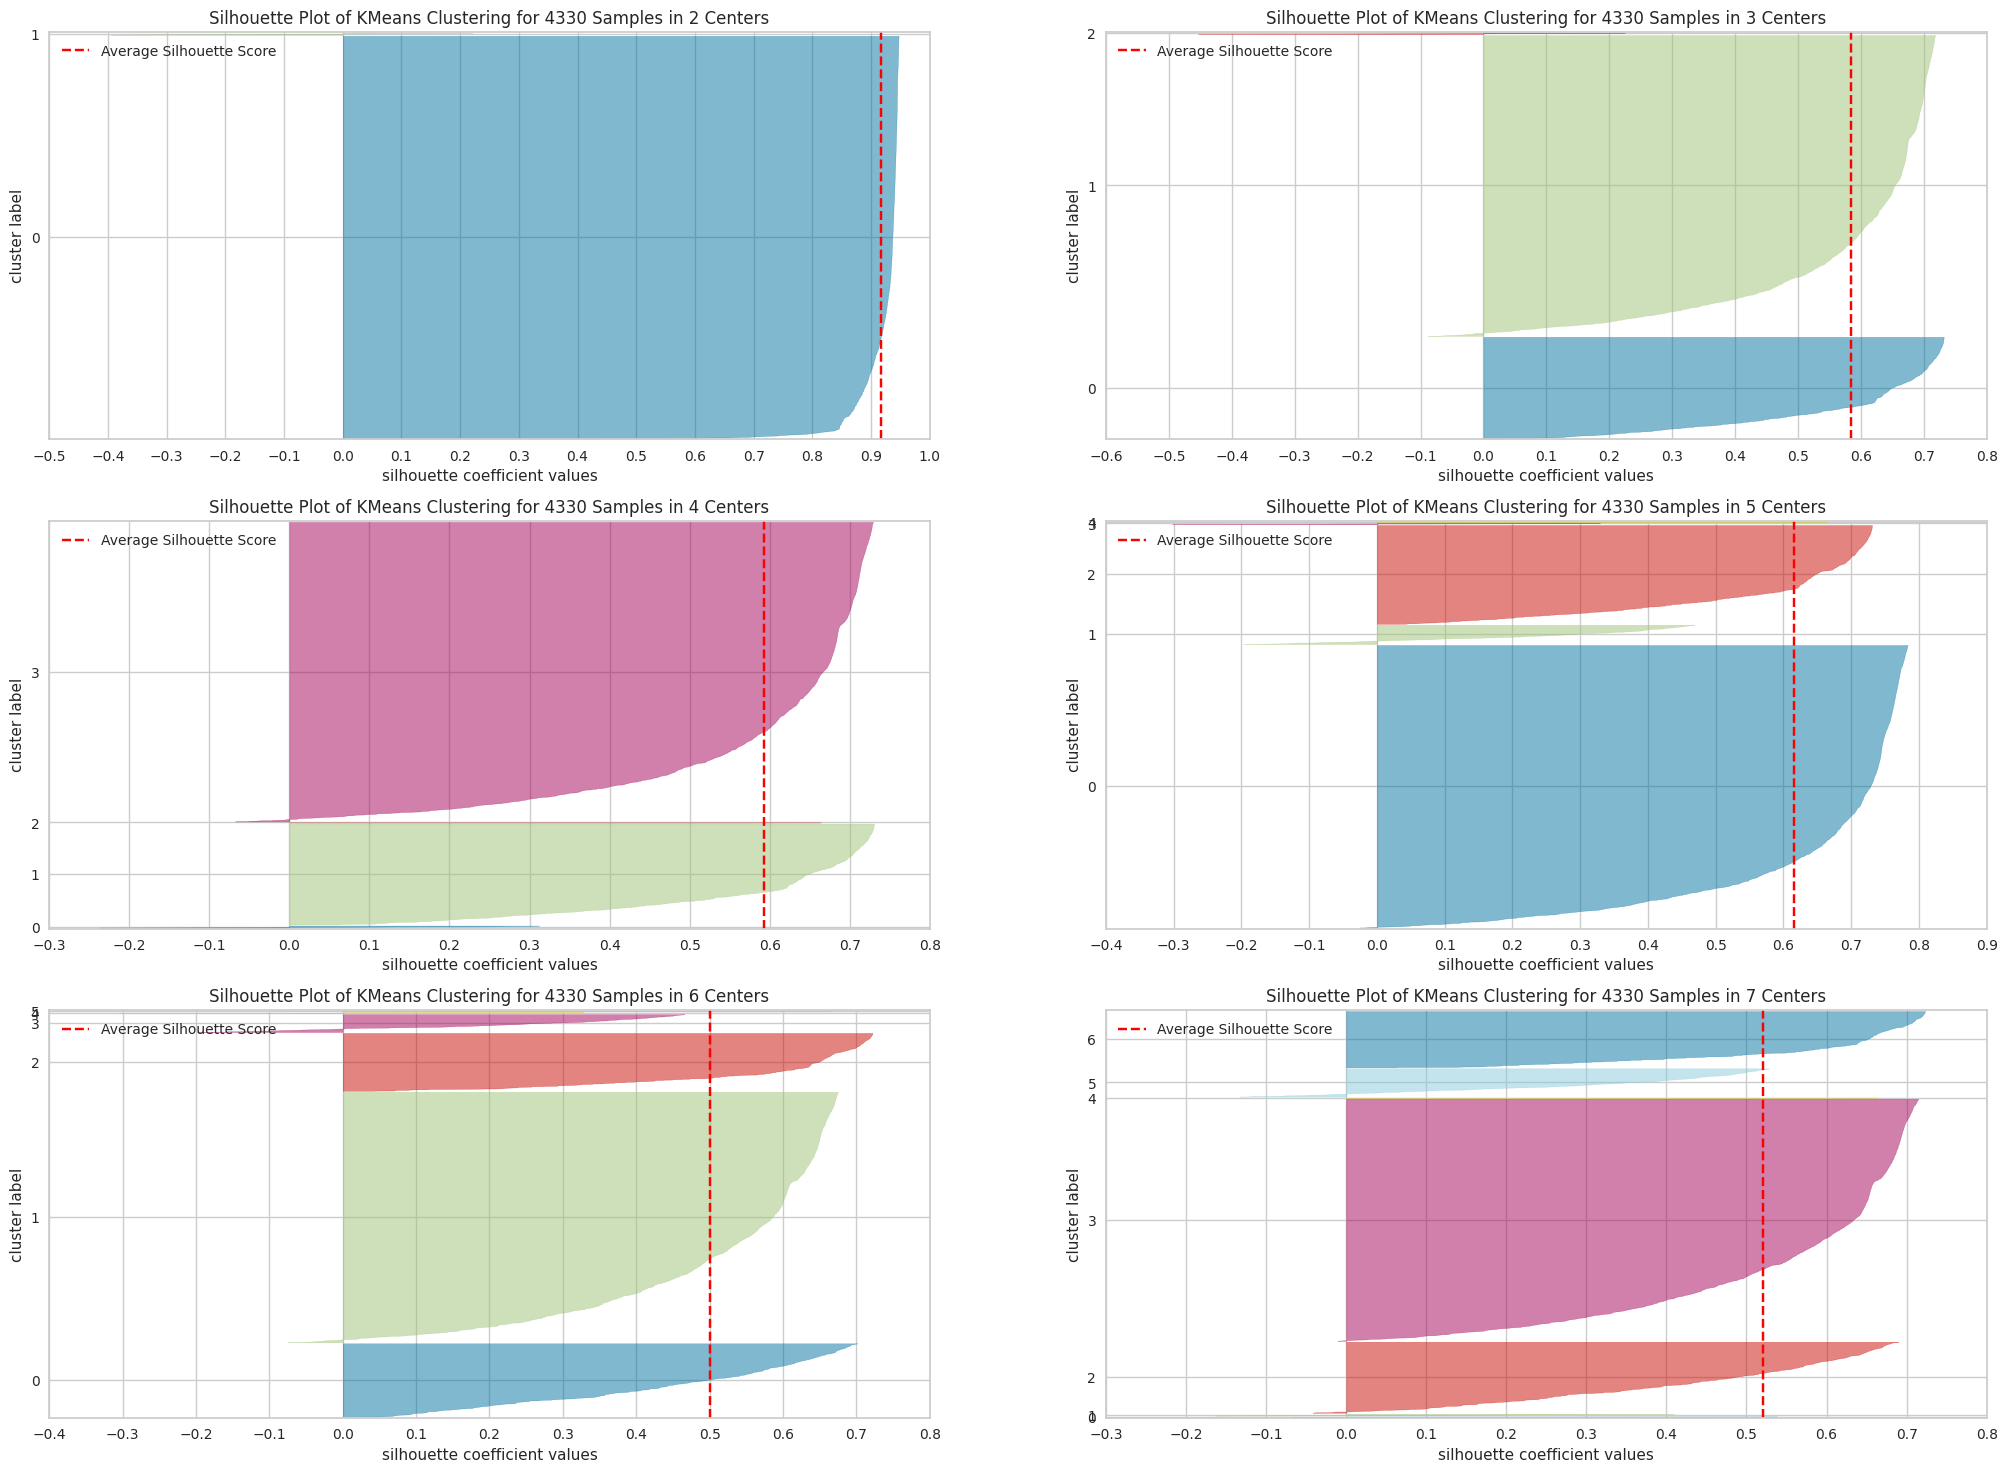

In [276]:
fig, ax = plt.subplots(3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans(n_clusters=k, n_init=10, init='random', max_iter = 100, random_state = 42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax= ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [343]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters = k, n_init= 10, max_iter = 500, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [344]:
print(f'WSS:{kmeans.inertia_}')
print(f'SS:{mt.silhouette_score(X, labels)}')

WSS:9312.775671685537
SS:0.5842444203410007


# 9.0 Cluster Analysis

In [345]:
df9 = df6.copy()
df9['cluster'] = labels


## 9.1 Visualization Inspection Silhouette

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


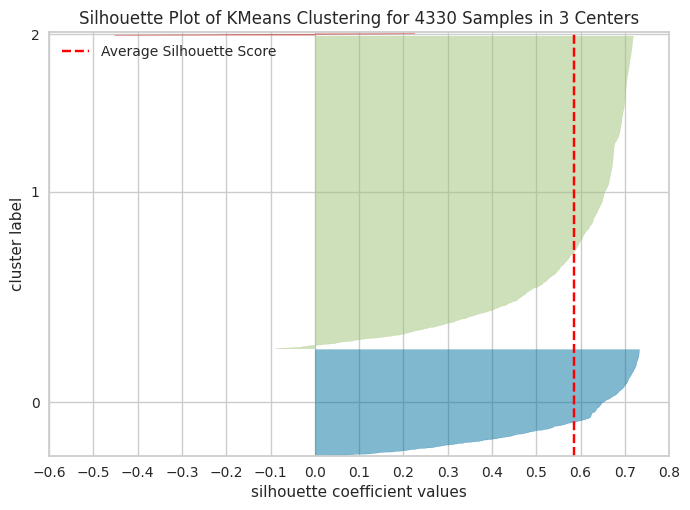

In [350]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D Plot

In [347]:
df_viz = df9.drop(columns='customer_id', axis = 1)
# sns.pairplot(df_viz, hue = 'cluster')

## 9.3 UMAP

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

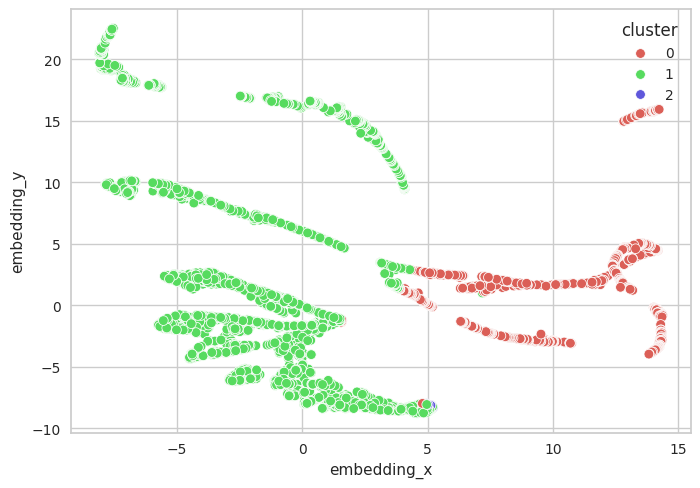

In [348]:
reducer = umap.UMAP(n_neighbors=30, random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette = sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data = df_viz)


## 9.4 Cluster Profile

In [349]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg gross_revenue
df_gross = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross, on='cluster', how='left')


# Avg recency_days
df_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, on='cluster', how='left')

# Avg invoice_no
df_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, on='cluster', how='left')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster', how='left')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,1090,25.17321,-0.164694,1.534952,-0.350594,-0.008771
1,1,3225,74.48037,-0.005221,-0.515793,0.075840,-0.025421
2,2,15,0.34642,13.090267,-0.644322,9.170788,6.102805


### Cluster 01: (Candidato à Insider)
    - Número de Customers: 6 (0.13% do customers)
    - Recência em Média: 7 dias
    - Compras em média no último ano: 89 compras
    - Receita em média no último ano: $182.182,00

### Cluster 02: 
    - Número de Customers: 31 (0.71% do customers)
    - Recência em Média: 14 dias
    - Compras em média no último ano: 53 compras
    - Receita em média no último ano: $40.543,52

### Cluster 03: 
    - Número de Customers: 4335 (99% do customers)
    - Recência em Média: 92 dias
    - Compras em média no último ano: 5 compras
    - Receita em média no último ano: $1.372,57

# 10.0 Deploy To Production